In [1]:
import pandas as pd
import numpy as np
import data
import plot as pt
from matplotlib import pyplot as plt

In [2]:
df = data.get_data()
df = data.excess_return_unit(df)
df = data.exponential_moving_averages(df, col='SPY')
df = data.kelly_fraction(df, col='Excess Return')
df = data.moving_averages(df, col='SPY')
df = df.fillna(df['SPY'][0])

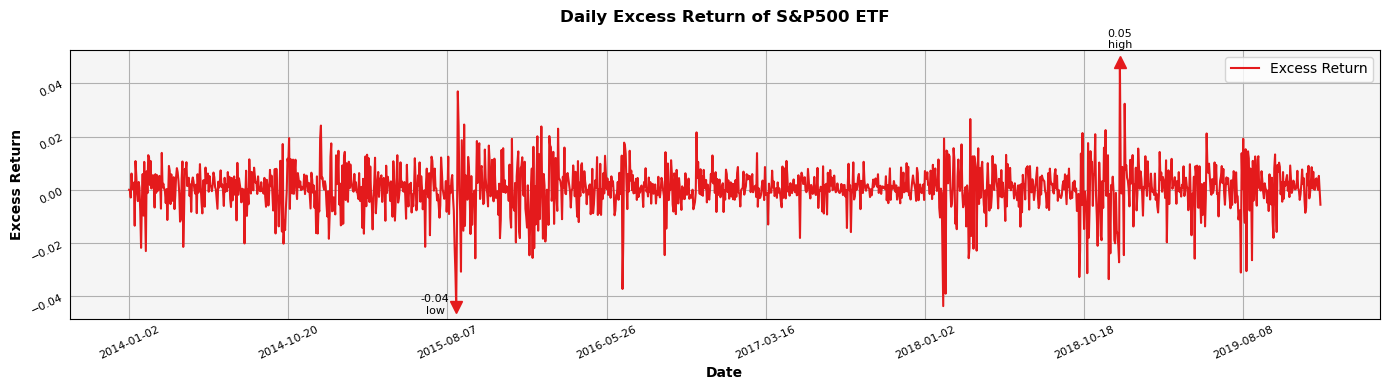

In [3]:
pt.plot_time_series_annotated(df=df, ylabel='Excess Return',x_col='Date', y_cols=['Excess Return'], title='Daily Excess Return of S&P500 ETF')

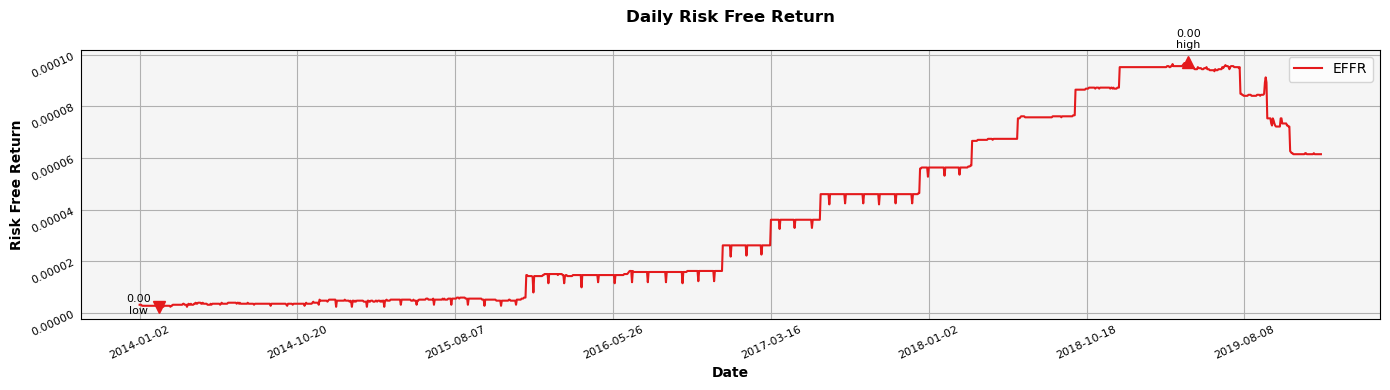

In [4]:
pt.plot_time_series_annotated(df=df, ylabel='Risk Free Return', x_col='Date', y_cols=['EFFR'], title='Daily Risk Free Return')

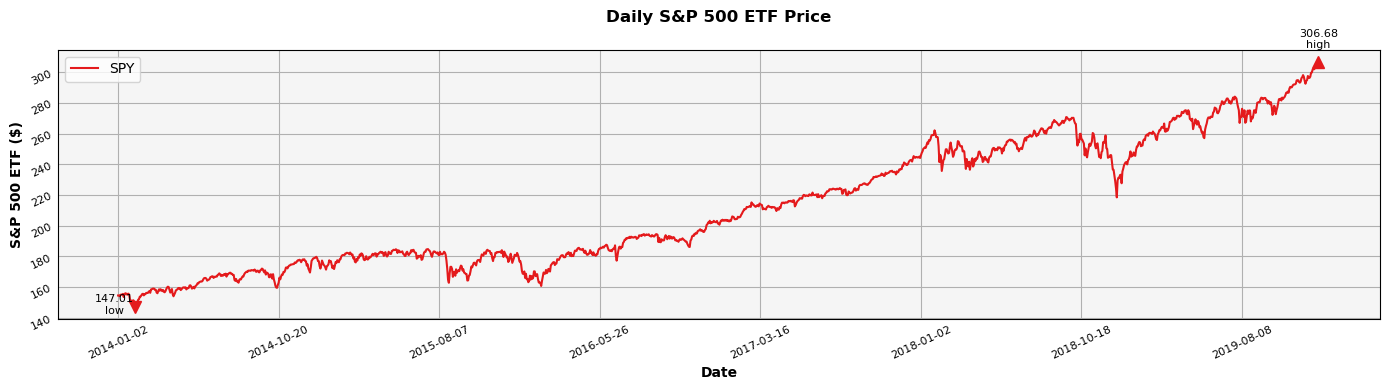

In [5]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['SPY'], title='Daily S&P 500 ETF Price')

In [6]:
df.columns.to_list()

['SPY',
 'Volume',
 'EFFR',
 'Date',
 'Time',
 'Price Change',
 'Excess Return',
 '10 EMA SPY',
 '20 EMA SPY',
 '30 EMA SPY',
 'Kelly Fraction',
 '10 MA SPY',
 '20 MA SPY',
 '30 MA SPY']

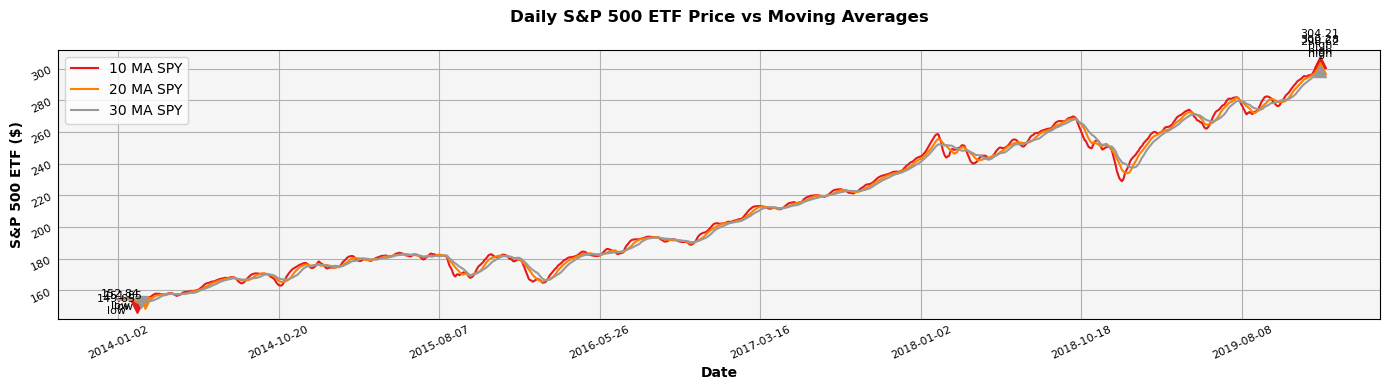

In [7]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10 MA SPY', '20 MA SPY', '30 MA SPY'], title='Daily S&P 500 ETF Price vs Moving Averages')

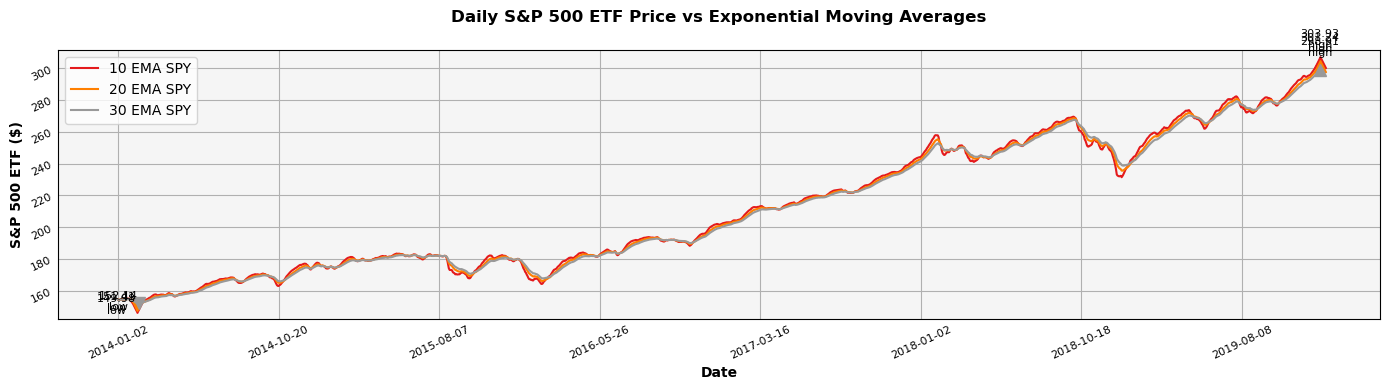

In [8]:
pt.plot_time_series_annotated(df=df, ylabel='S&P 500 ETF ($)', x_col='Date', y_cols=['10 EMA SPY', '20 EMA SPY', '30 EMA SPY'], title='Daily S&P 500 ETF Price vs Exponential Moving Averages')

In [68]:
def bollinger_band_strategy(df, col='SPY', start_val = 2*(10**5), leverage=5, drop_lim = -0.02, window=20, sigma=2):
    """
    Buys and sells SPY stock based on the bollinger band strategy.
    If the price is below the lower band, buy.
    If the price is above the upper band, sell.
    """
    
    df = data.bollinger_bands(df, col=col, window=window, sigma=sigma)

    hold_stock = False

    signal = np.zeros(len(df))
    position = np.zeros(len(df))
    account = np.zeros(len(df))

    account[0] = start_val
  
    money_owed = 0
    trade_amount_list = [0]

    for i in range(1,len(df)):
        
        # buy signal 
        if df[col][i-1] < df['BB Lower'][i-1] and not hold_stock:
            signal[i] = 1
            hold_stock = True
            trade_amount = account[i-1] * leverage
            money_owed = account[i-1] * (leverage - 1)

        # sell signal (stop loss or bb upper)
        elif ( df[col][i-1] > df['BB Upper'][i-1] or df['Price Change'][i] < drop_lim ) and hold_stock:
            signal[i] = -1
            hold_stock = False
            money_owed = 0
        
        if hold_stock:
            position[i] = 1
            money_owed = money_owed * (1 + df['EFFR'][i])
            trade_amount = trade_amount * (1 +  df['Excess Return'][i] )
            account[i] = trade_amount  - money_owed

        else:
            account[i] = account[i-1] * ( 1 + df['EFFR'][i])
        
        try:
            trade_amount_list.append(trade_amount)
        
        except UnboundLocalError:
            trade_amount_list.append(0)
        

    df['Account'] = account - money_owed
    df['Signal'] = signal
    df['Position'] = position
    df['Leverage'] = np.array(trade_amount_list / account) - 1
    df['Trade Amount'] = np.array(trade_amount_list)
    df['Theta'] = np.array([df['Account'][i] if df['Position'][i] == 1 else 0 for i in range(len(df))])

    return df

In [69]:
n_train = int( len(df) * 0.7 )
df_train = df[:n_train]
df_test = df[n_train:]

In [70]:
def cross_val_bollinger_band_strategy(df):
    """
    Cross validates the bollinger band strategy.
    """
    best_acc = 0
    for window in [5, 10, 20, 30]:
        for sigma in [1,2,3,4]:
            for drop_lim in [-0.01, -0.02, -0.03, -0.04, -0.05]:
                df = bollinger_band_strategy(df, window=window, sigma=sigma, drop_lim=drop_lim)
                if df['Account'].iloc[-1] > best_acc:
                    best_acc = df['Account'].iloc[-1]
                    best_window = window
                    best_sigma = sigma
                    best_drop_lim = drop_lim
    
    print('Best window: ', best_window)
    print('Best sigma: ', best_sigma)
    print('Best drop limit: ', best_drop_lim)
    
    return best_acc, best_window, best_sigma, best_drop_lim

In [71]:
best_acc, best_window, best_sigma, best_drop_lim = cross_val_bollinger_band_strategy(df_train)

Best window:  20
Best sigma:  1
Best drop limit:  -0.01


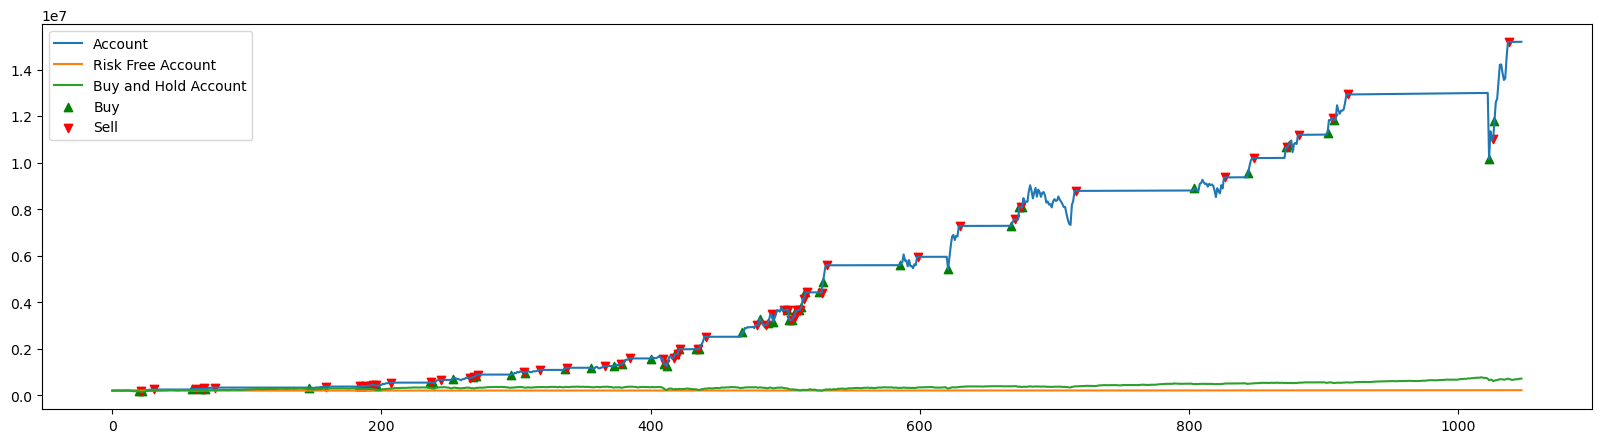

In [72]:
df_train = bollinger_band_strategy(df_train, col='SPY', window=best_window, sigma=best_sigma, drop_lim=best_drop_lim)
pt.plot_strategy(df_train)

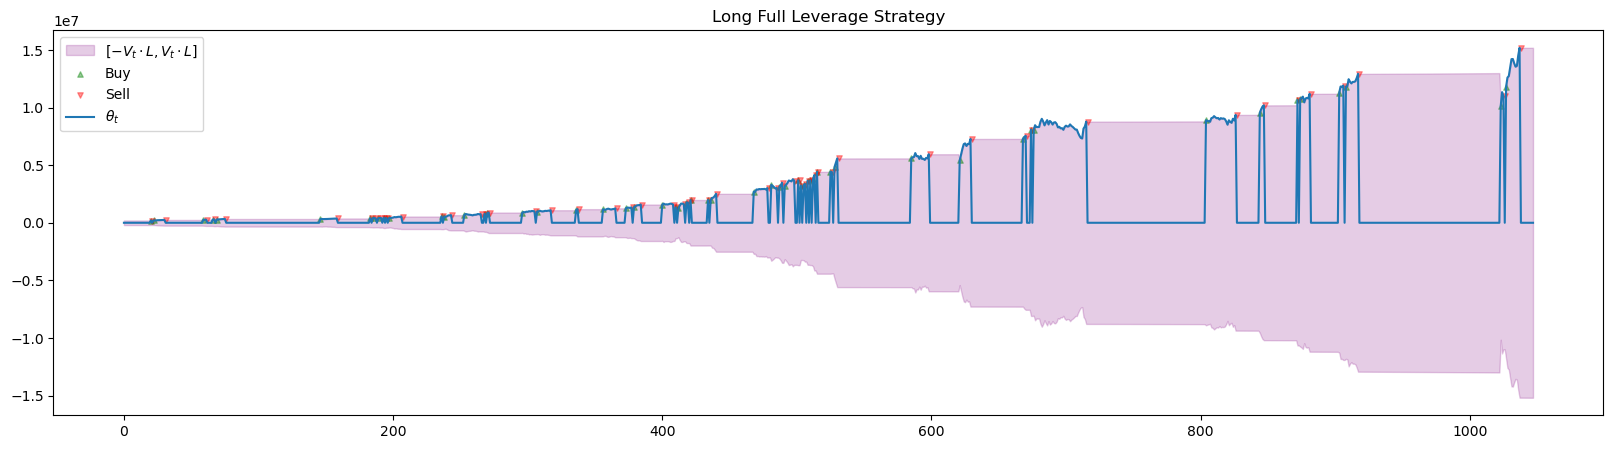

In [73]:
pt.plot_margin_bollinger_strategy(df_train)


In [74]:
# re index the test data
df_test = df_test.reset_index(drop=True)
df_test = bollinger_band_strategy(df_test, col='SPY', window=best_window, sigma=best_sigma, drop_lim=best_drop_lim)

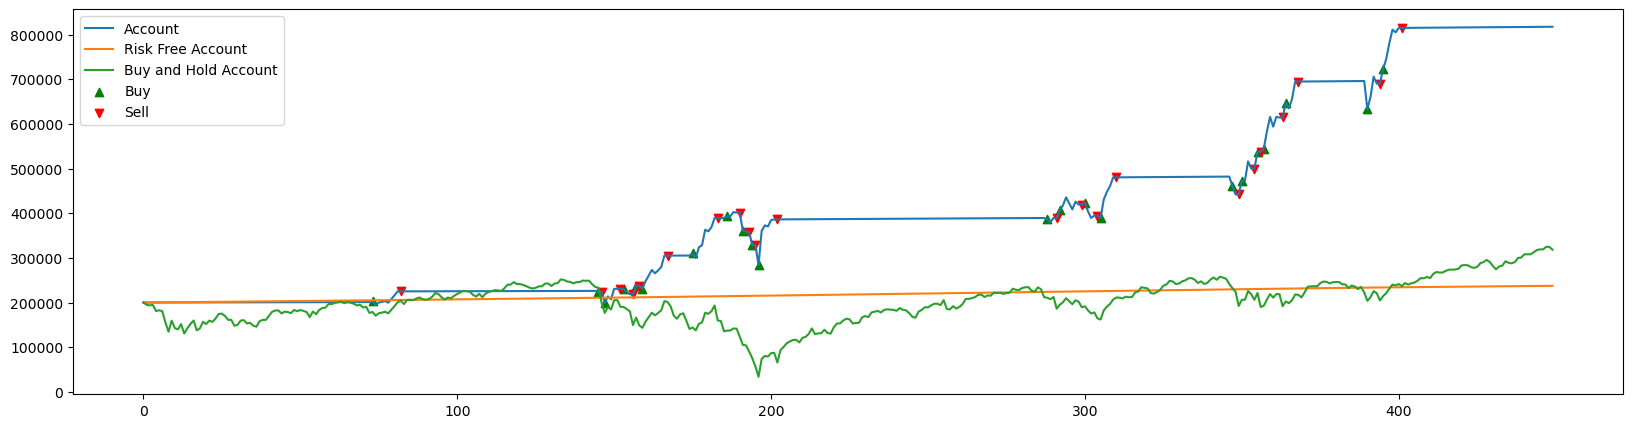

In [75]:
pt.plot_strategy(df_test)

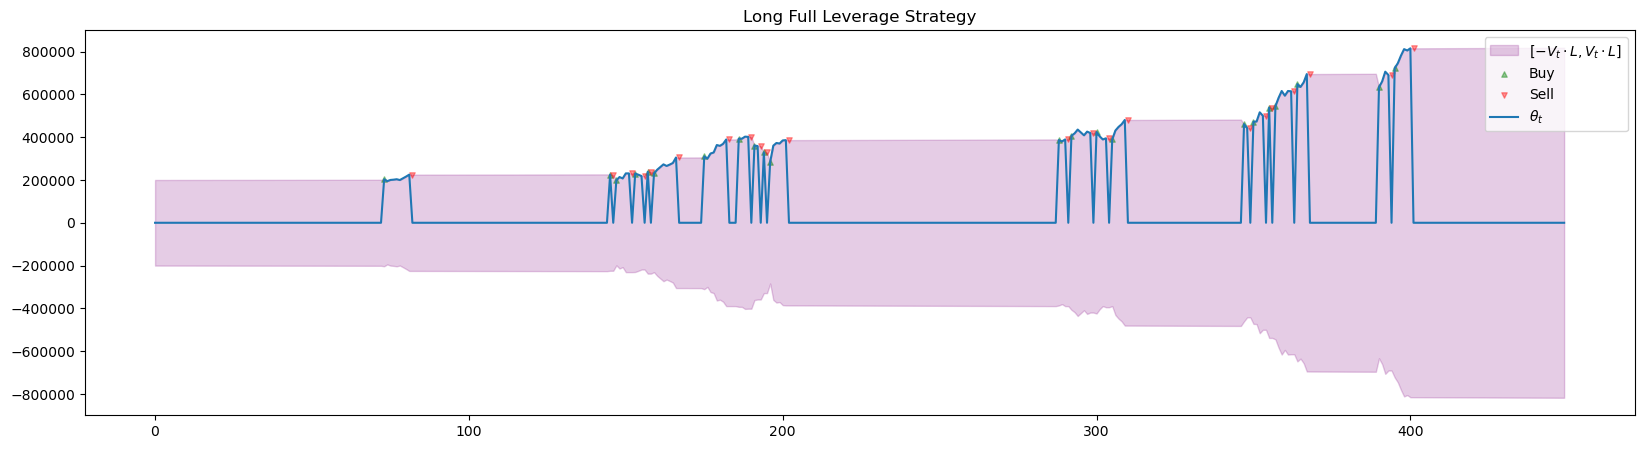

In [76]:
pt.plot_margin_bollinger_strategy(df_test)

In [65]:
def turnover_dollars(df):
    """
    Calculates the turnover in dollars.
    """
    df = df[(df['Position'] == 1) | (df['Position'] == -1)]
    turnover = df['Theta'].diff().sum()
    return turnover

turnover_dollars(df_train)

14990540.317109272

In [151]:
def turnover_units(df):
    """
    Calculates the turnover in units.
    """
    df = df[df['Theta'] != 0]
    df = df.reset_index(drop=True)
    turnover_units = np.sum([ abs( df['Theta'][i+1] / df['SPY'][i+1] - df['Theta'][i] / df['SPY'][i] ) for i in range(len(df)-1)])
    return turnover_units

turnover_units(df_train)

2415.3663446652736

In [37]:
def delta_value(df):
    """
    Calculates the change in value of the portfolio.
    """
    delta_v = df['Excess Return'] * df['Theta']
    return delta_v

def delta_cap(df, leverage_limit=5):
    """
    Calculates the capped change in value of the portfolio by 
    the leverage limit.
    """
    delta_v_total = df['Account']
    M = df['Theta'].abs() / leverage_limit
    delta_v_cap = (delta_v_total - M) * df['EFFR']

    return delta_v_cap

def delta_total_value(df):
    """
    Calculates the total change in value of the portfolio.
    """
    delta_v = delta_value(df)
    delta_v_cap = delta_cap(df)
    delta_v_total =  delta_v + delta_v_cap
    return delta_v_total


In [152]:
# TODO verify the calculations of the following metrics

def sharpe_ration(df):
    """
    Calculates the sharpe ratio of the portfolio.
    """
    delta_v_total = delta_total_value(df)
    sharpe_ratio = delta_v_total.mean() / delta_v_total.std()
    return sharpe_ratio

def sortino_ratio(df):
    """
    Calculates the sortino ratio of the portfolio.
    """
    delta_v_total = delta_total_value(df)
    sortino_ratio = delta_v_total.mean() / delta_v_total[delta_v_total < 0].std()
    return sortino_ratio

def max_drawdown(df):
    """
    Calculates the maximum drawdown of the portfolio.
    """
    max_drawdown = (df['Account'] / df['Account'].cummax() - 1).min()
    return max_drawdown

def calmar_ratio(df):
    """
    Calculates the calmar ratio of the portfolio.
    """
    calmar_ratio = sharpe_ration(df) / max_drawdown(df)
    return calmar_ratio


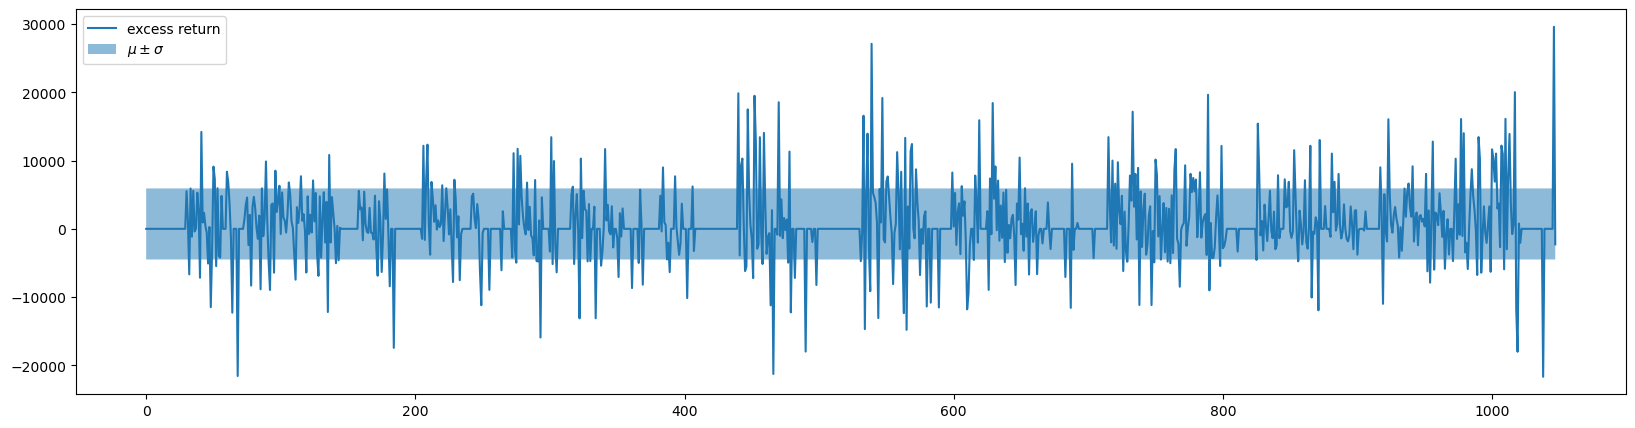

In [153]:
def excess_return_account(df):
    """
    Calculates the excess return of the portfolio.
    """
    excess_return = df['Excess Return'] * df['Theta']
    return excess_return

excess_return = excess_return_account(df_train)
plt.plot(excess_return, label='excess return')
plt.fill_between(np.arange(len(excess_return)), excess_return.mean() - excess_return.std(), excess_return.mean() + excess_return.std(), alpha=0.5, label = '$\mu \pm \sigma$')
plt.legend()

In [238]:
def momentum_strategy(df, col='SPY', start_val = 2 * (10**5), leverage=5, window='20',  sigma=2):
    """
    A momentum trading strategy that incorporates leverage.
    
    Parameters:
    df (pandas.DataFrame): A DataFrame containing the price data for the stock
    capital (float): The amount of unlevered capital to start with
    lookback_period (int): The number of days to use in the momentum calculation
    buy_threshold (float): The threshold for the momentum value to trigger a buy signal
    sell_threshold (float): The threshold for the momentum value to trigger a sell signal
    leverage (float): The amount of leverage to use in the strategy
    
    Returns:
    float: The final unlevered capital value after executing the strategy
    """
    
    df = data.moving_averages(df, col)
    
    if window == '10':
        ma_col = f'10 MA {col}'
    
    elif window == '20':
        ma_col = f'20 MA {col}'
    
    else:
        ma_col = f'30 MA {col}' 

    hold_stock = False
    signal = np.zeros(len(df))
    position = np.zeros(len(df))
    account = np.zeros(len(df))
    accumulated_leverage = np.zeros(len(df))

    account[0] = start_val * leverage

    for i in range(1, len(df)):

        # buy signal
        if (df[col][i-1] > df[ma_col][i-1] + sigma) and hold_stock == False:
            signal[i] = 1
            hold_stock = True
        
        # sell signal
        elif (df[col][i] < df[ma_col][i] - sigma ) and hold_stock == True:
            signal[i] = -1
            hold_stock = False

        if hold_stock == True:
            position[i] = 1
            account[i] = account[i-1] * (1 + df['Excess Return'][i])
            profit = account[i] - account[i-1]
            accumulated_leverage[i] = profit 
        
        else:
            account[i] = account[i-1] * (1 + df['EFFR'][i])
            profit = account[i] - account[i-1]
            accumulated_leverage[i] = profit
    
    accumulated_leverage = accumulated_leverage.cumsum() + start_val
    
    df['Signal'] = signal
    df['Position'] = position
    df['Account'] = account
    df['Leverage'] = accumulated_leverage
    df['Theta'] = np.array([df['Account'][i] if df['Position'][i] == 1 else 0 for i in range(len(df))])

    return df


In [239]:
def cross_val_momentum_strategy(df):

    best_acc = 0
    best_window = 0
    best_sigma = 0
    for window in [10,20,30]:
        for sigma in [0, 0.05, 0.5, 1,2,3]:
            df_new = momentum_strategy(df, window=window, sigma=sigma)
            if df_new['Account'].iloc[-1] > best_acc:
                best_window = window
                best_sigma = sigma
                best_acc = df_new['Account'].iloc[-1]
    
    print(f'Best window: {best_window}')
    print(f'Best sigma: {best_sigma}')
    df = momentum_strategy(df, window=best_window, sigma=best_sigma)

    return df, best_window, best_sigma

In [240]:
df_momentum_train, best_window, best_sigma = cross_val_momentum_strategy(df_train)

Best window: 10
Best sigma: 0


In [241]:
df_momentum_test = momentum_strategy(df_test, window=best_window, sigma=best_sigma)

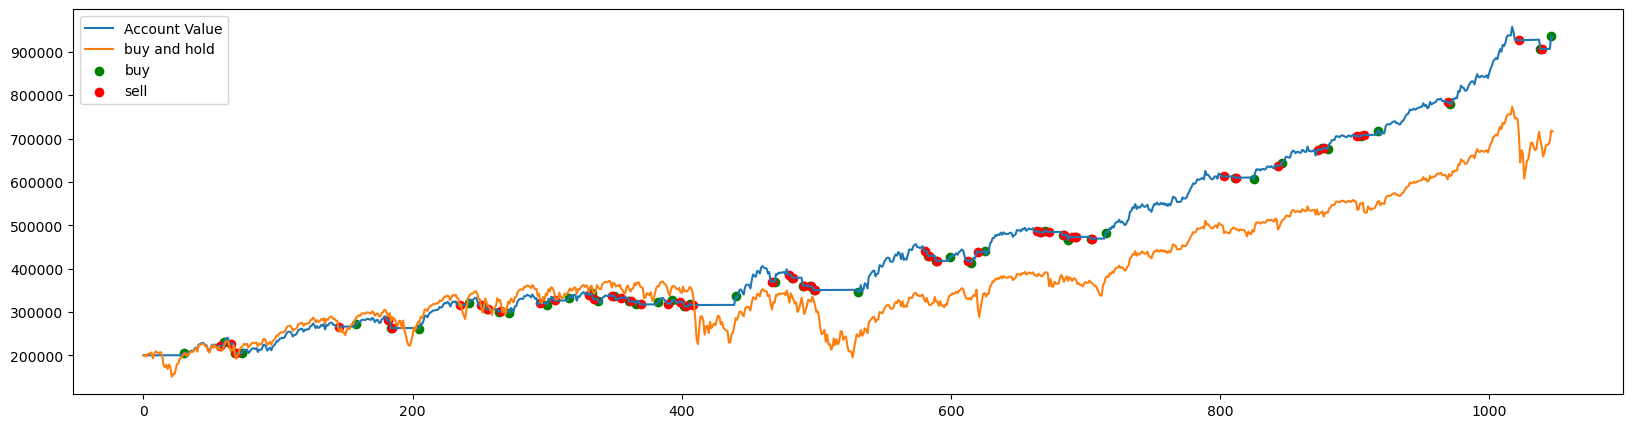

In [242]:
plt.plot(df_momentum_train['Account'] - 8*(10**5), label='Account Value')
plt.plot(df_train['Buy and Hold Account'], label='buy and hold')

mask_buy = df_momentum_train['Signal'] == 1
mask_sell = df_momentum_train['Signal'] == -1

plt.scatter(df_momentum_train[mask_buy].index, df_momentum_train[mask_buy]['Account'] - 8*(10**5), color='green', label='buy')
plt.scatter(df_momentum_train[mask_sell].index, df_momentum_train[mask_sell]['Account'] - 8*(10**5), color='red', label='sell')


plt.legend()

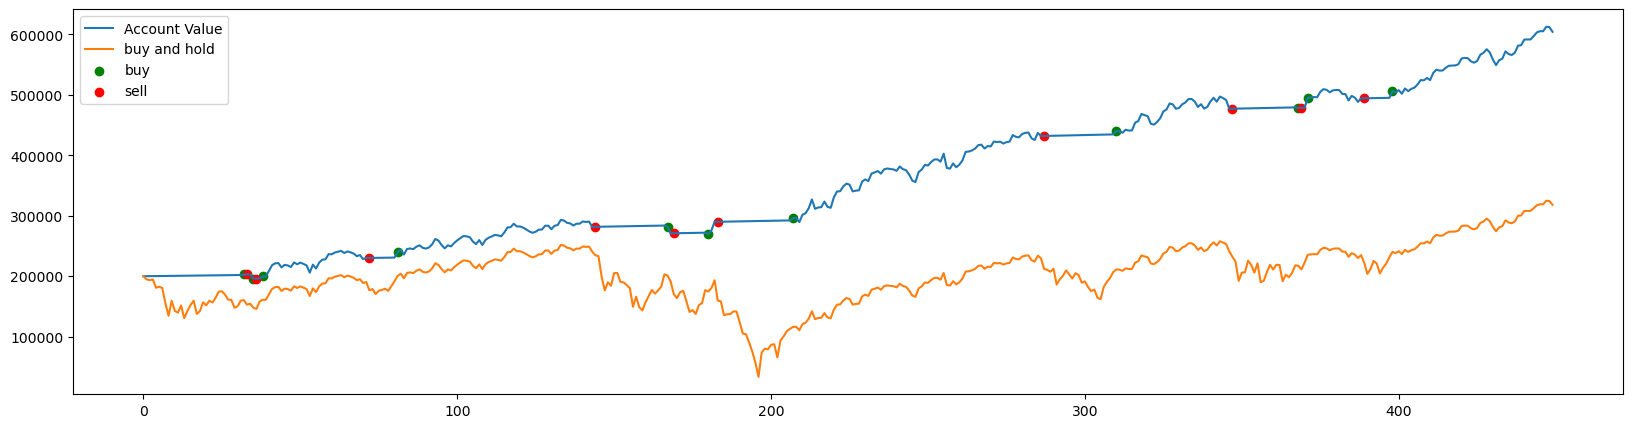

In [243]:
plt.plot(df_momentum_test['Account'] - 8*(10**5), label='Account Value')
plt.plot(df_test['Buy and Hold Account'], label='buy and hold')

mask_buy = df_momentum_test['Signal'] == 1
mask_sell = df_momentum_test['Signal'] == -1

plt.scatter(df_momentum_test[mask_buy].index, df_momentum_test[mask_buy]['Account'] - 8*(10**5), color='green', label='buy')
plt.scatter(df_momentum_test[mask_sell].index, df_momentum_test[mask_sell]['Account'] - 8*(10**5), color='red', label='sell')

plt.legend()

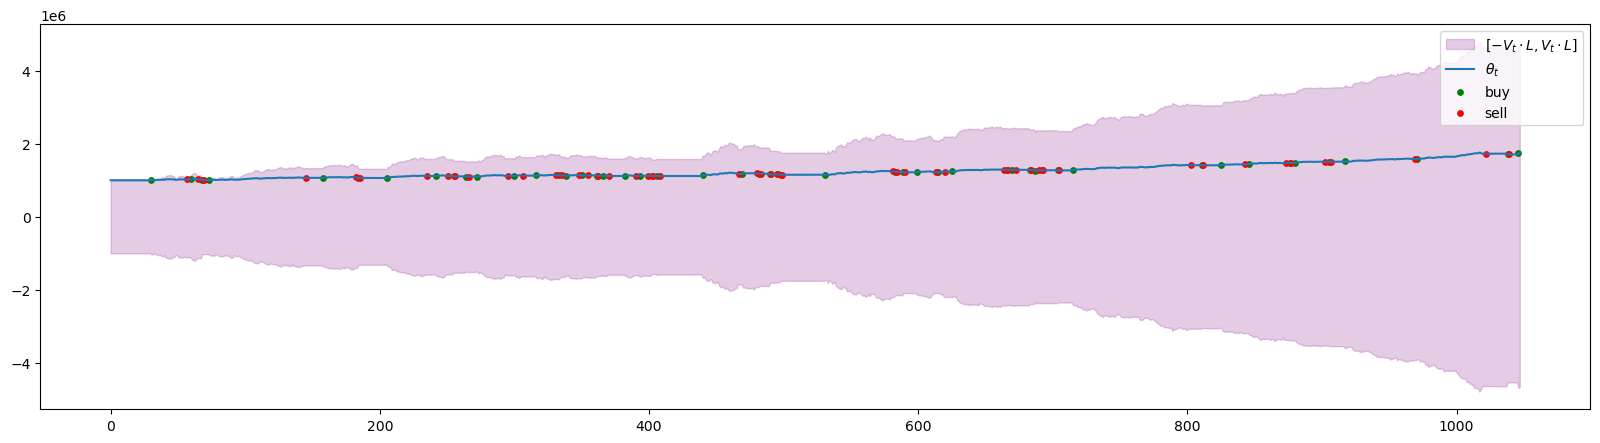

In [250]:
plt.fill_between(x = df_momentum_train.index, 
                 y1 = df_momentum_train['Leverage']*5, 
                 y2 = -(df_momentum_train['Leverage']*5),
                 label='$[ - V_t \cdot L, V_t \cdot L]$',
                 alpha=0.2,
                 color='purple')
plt.plot(df_momentum_train['Account'], label='$\\theta_t$')

mask_buy = df_momentum_train['Signal'] == 1
mask_sell = df_momentum_train['Signal'] == -1

plt.scatter(df_momentum_train[mask_buy].index, df_momentum_train[mask_buy]['Account'], color='green', label='buy', s=15)
plt.scatter(df_momentum_train[mask_sell].index, df_momentum_train[mask_sell]['Account'], color='red', label='sell', s=15)

plt.legend()